In [10]:
import pandas as pd
import numpy as np
import psycopg2
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# cleaning and converting data types
def clean_and_convert_data_types(df):
    for column in df.columns:
        try:
            # Attempt to convert to integer
            df[column] = pd.to_numeric(df[column], errors='raise').astype('Int64')
        except (ValueError, TypeError):
            try:
                # Attempt to convert to float
                df[column] = pd.to_numeric(df[column], errors='raise')
            except (ValueError, TypeError):
                try:
                    # Attempt to convert to datetime
                    df[column] = pd.to_datetime(df[column], errors='raise')
                except (ValueError, TypeError):
                    pass
    return df

# replacing NaN values
def replace_nan_values(df):
    for column in df.columns:
        if df[column].dtype == 'O':  # Check if datatype is object (string)
            df[column] = df[column].fillna('UNKNOWN')
        elif pd.api.types.is_numeric_dtype(df[column].dtype):  # Check if datatype is numeric
            df[column] = df[column].fillna(0)
        elif pd.api.types.is_datetime64_dtype(df[column].dtype):  # Check if datatype is datetime
            mode_value = df[column].mode().iloc[0]  # Calculate mode
            df[column] = pd.to_datetime(df[column], errors='coerce').fillna(mode_value)
    return df
# checking if a table exists
def table_exists(cursor, table_name):
    cursor.execute("""
        SELECT EXISTS (
            SELECT 1
            FROM information_schema.tables
            WHERE table_name = %s
        )
    """, (table_name,))
    return cursor.fetchone()[0]

def create_table_if_not_exists(connection, cursor, table_name, table_schema):
    if not table_exists(cursor, table_name):
        cursor.execute(table_schema)
        connection.commit()

# transforming and loading data into PostgreSQL with batch processing
def transform_and_load_to_postgres_batch(cleaned_data, connection_params, table_name, table_schema, batch_size=1000):
    connection = psycopg2.connect(**connection_params)
    cursor = connection.cursor()

    # Create the table if it doesn't exist
    create_table_if_not_exists(connection, cursor, table_name, table_schema)
    for start_index in range(0, len(cleaned_data), batch_size):
        end_index = start_index + batch_size
        batch_data = cleaned_data.iloc[start_index:end_index]

        for index, row in batch_data.iterrows():
            id, price, minimum_nights, last_review, reviews_per_month = row['id'], row['price'], row['minimum_nights'], row['last_review'], row['reviews_per_month']
            cursor.execute("SELECT * FROM warehouse_table WHERE id = %s", (id,))
            existing_record = cursor.fetchone()

            if existing_record:
                if (
                    existing_record[9] != price or
                    existing_record[10] != minimum_nights or
                    existing_record[11] != last_review or
                    existing_record[12] != reviews_per_month
                ):
                    cursor.execute("""
                        UPDATE warehouse_table
                        SET
                            price = %s,
                            minimum_nights = %s,
                            last_review = %s,
                            reviews_per_month = %s,
                            last_updated_date = CURRENT_DATE
                        WHERE
                            id = %s
                    """, (price, minimum_nights, last_review, reviews_per_month, id))
            else:
                cursor.execute("""
                    INSERT INTO warehouse_table (
                        id, name, host_id, host_name, neighbourhood_group, neighbourhood,
                        latitude, longitude, room_type, price, minimum_nights, number_of_reviews,
                        last_review, reviews_per_month, calculated_host_listings_count,
                        availability_365, last_updated_date
                    )
                    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, CURRENT_DATE)
                """, (
                    id, row['name'], row['host_id'], row['host_name'],
                    row['neighbourhood_group'], row['neighbourhood'], row['latitude'],
                    row['longitude'], row['room_type'], price, minimum_nights,
                    row['number_of_reviews'], last_review, reviews_per_month,
                    row['calculated_host_listings_count'], row['availability_365']
                ))
            

    connection.commit()

    cursor.close()
    connection.close()


def execute_data_pipeline(raw_data_path, connection_params, table_name, table_schema, batch_size=1000):
    raw_data = pd.read_csv(raw_data_path)
    cleaned_data = clean_and_convert_data_types(raw_data)
    cleaned_data = replace_nan_values(cleaned_data)

    transform_and_load_to_postgres_batch(cleaned_data, connection_params, table_name, table_schema, batch_size)

raw_data_path = 'ABNB_NYC_2019.csv'
connection_params = {
    "user": "rk",
    "password": "Cvs@9154",
    "host": "localhost",
    "port": "5432",
    "database": "airbnb"
}
table_name = 'warehouse_table'
table_schema = """
    CREATE TABLE warehouse_table (
        id INT PRIMARY KEY,
        name VARCHAR(255),
        host_id INT,
        host_name VARCHAR(255),
        neighbourhood_group VARCHAR(255),
        neighbourhood VARCHAR(255),
        latitude FLOAT,
        longitude FLOAT,
        room_type VARCHAR(50),
        price INT,
        minimum_nights INT,
        number_of_reviews INT,
        last_review DATE,
        reviews_per_month FLOAT,
        calculated_host_listings_count INT,
        availability_365 INT,
        last_updated_date DATE
    )
"""

execute_data_pipeline(raw_data_path, connection_params, table_name, table_schema, batch_size=1000)


## TESTING

Giving updated CSV file as input and checking if update is reflected in database table or not.

In [11]:
import pandas as pd
import numpy as np
import psycopg2
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

def clean_and_convert_data_types(df):
    for column in df.columns:
        try:
            # Attempt to convert to integer
            df[column] = pd.to_numeric(df[column], errors='raise').astype('Int64')
        except (ValueError, TypeError):
            try:
                # Attempt to convert to float
                df[column] = pd.to_numeric(df[column], errors='raise')
            except (ValueError, TypeError):
                try:
                    # Attempt to convert to datetime
                    df[column] = pd.to_datetime(df[column], errors='raise')
                except (ValueError, TypeError):
                    pass
    return df

# Function for replacing NaN values
def replace_nan_values(df):
    for column in df.columns:
        if df[column].dtype == 'O':  # Check if datatype is object (string)
            df[column] = df[column].fillna('UNKNOWN')
        elif pd.api.types.is_numeric_dtype(df[column].dtype):  # Check if datatype is numeric
            df[column] = df[column].fillna(0)
        elif pd.api.types.is_datetime64_dtype(df[column].dtype):  # Check if datatype is datetime
            mode_value = df[column].mode().iloc[0]  # Calculate mode
            df[column] = pd.to_datetime(df[column], errors='coerce').fillna(mode_value)
    return df
# Function for checking if a table exists
def table_exists(cursor, table_name):
    cursor.execute("""
        SELECT EXISTS (
            SELECT 1
            FROM information_schema.tables
            WHERE table_name = %s
        )
    """, (table_name,))
    return cursor.fetchone()[0]

def create_table_if_not_exists(connection, cursor, table_name, table_schema):
    if not table_exists(cursor, table_name):
        cursor.execute(table_schema)
        connection.commit()

# Function for transforming and loading data into PostgreSQL with batch processing
def transform_and_load_to_postgres_batch(cleaned_data, connection_params, table_name, table_schema, batch_size=1000):
    connection = psycopg2.connect(**connection_params)
    cursor = connection.cursor()

    # Create the table if it doesn't exist
    create_table_if_not_exists(connection, cursor, table_name, table_schema)

    # Batch processing
    for start_index in range(0, len(cleaned_data), batch_size):
        end_index = start_index + batch_size
        batch_data = cleaned_data.iloc[start_index:end_index]

        for index, row in batch_data.iterrows():
            id, price, minimum_nights, last_review, reviews_per_month = row['id'], row['price'], row['minimum_nights'], row['last_review'], row['reviews_per_month']

            # Check if the record exists in the warehouse_table
            cursor.execute("SELECT * FROM warehouse_table WHERE id = %s", (id,))
            existing_record = cursor.fetchone()

            if existing_record:
                # Check if there are changes in relevant columns
                if (
                    existing_record[9] != price or
                    existing_record[10] != minimum_nights or
                    existing_record[11] != last_review or
                    existing_record[12] != reviews_per_month
                ):
                    # Update the existing record with the new values and set last_updated_date
                    cursor.execute("""
                        UPDATE warehouse_table
                        SET
                            price = %s,
                            minimum_nights = %s,
                            last_review = %s,
                            reviews_per_month = %s,
                            last_updated_date = CURRENT_DATE
                        WHERE
                            id = %s
                    """, (price, minimum_nights, last_review, reviews_per_month, id))
            else:
                # Insert the new record into warehouse_table
                cursor.execute("""
                    INSERT INTO warehouse_table (
                        id, name, host_id, host_name, neighbourhood_group, neighbourhood,
                        latitude, longitude, room_type, price, minimum_nights, number_of_reviews,
                        last_review, reviews_per_month, calculated_host_listings_count,
                        availability_365, last_updated_date
                    )
                    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, CURRENT_DATE)
                """, (
                    id, row['name'], row['host_id'], row['host_name'],
                    row['neighbourhood_group'], row['neighbourhood'], row['latitude'],
                    row['longitude'], row['room_type'], price, minimum_nights,
                    row['number_of_reviews'], last_review, reviews_per_month,
                    row['calculated_host_listings_count'], row['availability_365']
                ))
            

    connection.commit()

    cursor.close()
    connection.close()


# Function to execute the data pipeline
def execute_data_pipeline(raw_data_path, connection_params, table_name, table_schema, batch_size=1000):
    # Load raw data
    raw_data = pd.read_csv(raw_data_path)

    # Clean and convert data types
    cleaned_data = clean_and_convert_data_types(raw_data)

    # Replace NaN values
    cleaned_data = replace_nan_values(cleaned_data)

    # Transform and load into PostgreSQL with batch processing
    transform_and_load_to_postgres_batch(cleaned_data, connection_params, table_name, table_schema, batch_size)

# Define the pipeline parameters
raw_data_path = 'ABNB_NYC_2019_updated.csv'
connection_params = {
    "user": "rk",
    "password": "Cvs@9154",
    "host": "localhost",
    "port": "5432",
    "database": "airbnb"
}
table_name = 'warehouse_table'
table_schema = """
    CREATE TABLE warehouse_table (
        id INT PRIMARY KEY,
        name VARCHAR(255),
        host_id INT,
        host_name VARCHAR(255),
        neighbourhood_group VARCHAR(255),
        neighbourhood VARCHAR(255),
        latitude FLOAT,
        longitude FLOAT,
        room_type VARCHAR(50),
        price INT,
        minimum_nights INT,
        number_of_reviews INT,
        last_review DATE,
        reviews_per_month FLOAT,
        calculated_host_listings_count INT,
        availability_365 INT,
        last_updated_date DATE
    )
"""

# Execute the data pipeline with batch processing
execute_data_pipeline(raw_data_path, connection_params, table_name, table_schema, batch_size=1000)


Updates are reflected in database table.

In [12]:
import psycopg2
import pandas as pd

connection = psycopg2.connect(
    user="rk",
    password="Cvs@9154",
    host="localhost",
    port="5432",
    database="airbnb"
)

def execute_query(query):
    return pd.read_sql_query(query, connection)

top_5_neighborhoods = """
SELECT neighbourhood, COUNT(*) AS num_listings
FROM warehouse_table
GROUP BY neighbourhood
ORDER BY num_listings DESC
LIMIT 5;
"""
first_result = execute_query(top_5_neighborhoods)
print("Top 5 neighborhoods with maximum listings:")
print(first_result)

# ii. Name of person with the second maximum number of listings
person_with_second_max_listings = """
SELECT host_name, COUNT(DISTINCT id) AS num_listings
FROM warehouse_table
GROUP BY host_name
ORDER BY num_listings DESC
LIMIT 1 OFFSET 1;
"""
second_result = execute_query(person_with_second_max_listings)
print("\nName of person with the second maximum number of listings:")
print(second_result)

# iii. Number of room type listings for every neighborhood
no_of_room_types_per_neighborhood = """
SELECT neighbourhood, room_type, COUNT(*) AS num_listings
FROM warehouse_table
GROUP BY neighbourhood, room_type
ORDER BY neighbourhood, num_listings DESC;
"""
third_result = execute_query(no_of_room_types_per_neighborhood)
print("\nNumber of room type listings for every neighborhood:")
print(third_result)

connection.close()


Top 5 neighborhoods with maximum listings:
        neighbourhood  num_listings
0        Williamsburg          3920
1  Bedford-Stuyvesant          3714
2              Harlem          2658
3            Bushwick          2465
4     Upper West Side          1971

Name of person with the second maximum number of listings:
  host_name  num_listings
0     David           403

Number of room type listings for every neighborhood:
     neighbourhood        room_type  num_listings
0         Allerton     Private room            26
1         Allerton  Entire home/apt            16
2    Arden Heights  Entire home/apt             3
3    Arden Heights     Private room             1
4         Arrochar     Private room            11
..             ...              ...           ...
535       Woodlawn      Shared room             1
536        Woodrow  Entire home/apt             1
537       Woodside     Private room           171
538       Woodside  Entire home/apt            63
539       Woodside      S

In [13]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connecting to the warehouse
connection = psycopg2.connect(
    user="rk",
    password="Cvs@9154",
    host="localhost",
    port="5432",
    database="airbnb"
)

# Query to retrieve data
query = """
    SELECT *
    FROM warehouse_table
"""

df = pd.read_sql_query(query, connection)

connection.close()








In [14]:
import plotly.express as px

df_avg_price = df.groupby('neighbourhood', as_index=False).agg({'price': 'mean', 'latitude': 'mean', 'longitude': 'mean'})

fig = px.scatter_mapbox(
    df_avg_price,
    lat='latitude',
    lon='longitude',
    color='price',
    title='Average Price of Airbnb Listings in New York Neighborhoods',
    labels={'latitude': 'Latitude', 'longitude': 'Longitude', 'price': 'Average Price'},
    hover_data=['neighbourhood'],  
    size_max=15,  
    mapbox_style="carto-positron", 
)

fig.update_layout(
    mapbox_center={'lat': 40.71, 'lon': -74.0060}, 
    mapbox_zoom=8.7,  
    coloraxis_colorbar=dict(title='Average Price'),
)

fig.show()


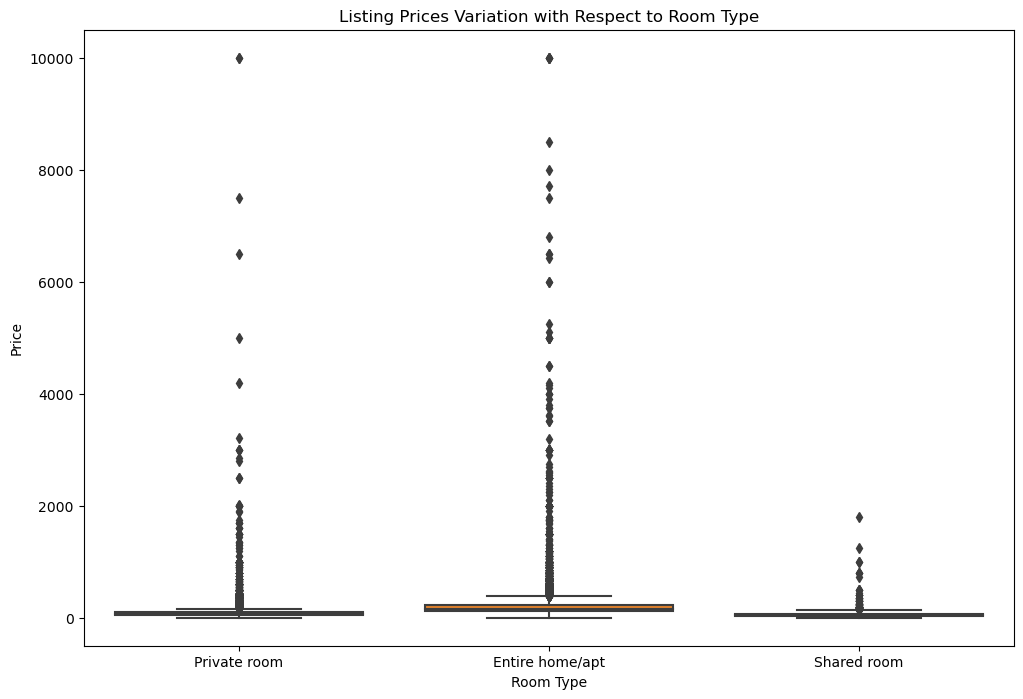

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.boxplot(x='room_type', y='price', data=df)
plt.title('Listing Prices Variation with Respect to Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.show()


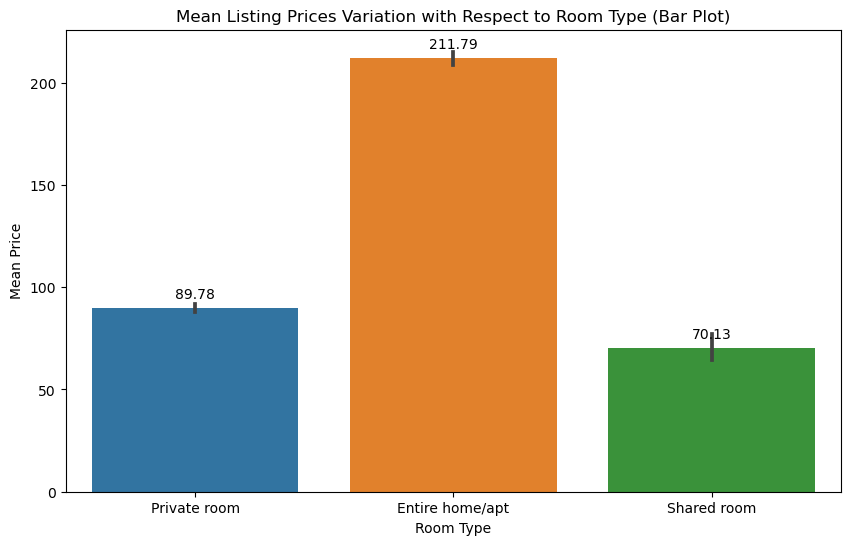

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='room_type', y='price', data=df, estimator=np.mean)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Mean Listing Prices Variation with Respect to Room Type (Bar Plot)')
plt.xlabel('Room Type')
plt.ylabel('Mean Price')
plt.show()


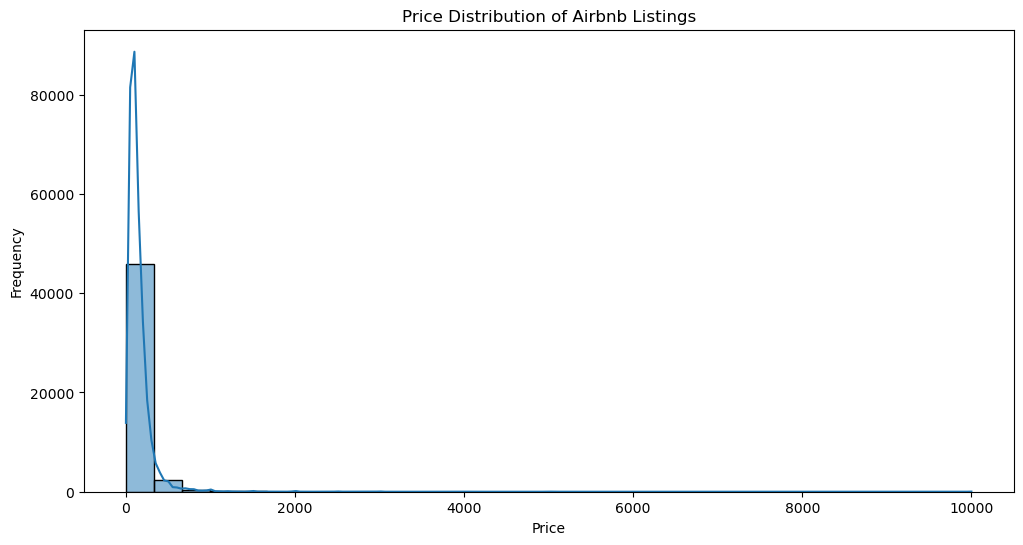

In [17]:

plt.figure(figsize=(12, 6))
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Price Distribution of Airbnb Listings')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()